## 动态滚动优化

In [1]:
from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'MultiFrameMaStrategy'
    author = u'用Python的交易员'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 40     # 快速均线参数
    slowWindow = 70     # 慢速均线参数
    initDays = 1       # 初始化数据所用的天数
    
    # 策略变量
    fastMa0 = EMPTY_FLOAT   # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT   # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT   # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT   # 上一根的慢速EMA
    maTrend = 0             # 均线趋势，多头1，空头-1
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1',
               'maTrend']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(MultiFrameMaStrategy, self).__init__(ctaEngine, setting)
        
        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        
        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }
        
        
        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }
        
        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
      
        self.am15Dict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        if not self.posDict:
            for symbolPos in [self.Longpos,self.Shortpos]:
                self.posDict[symbolPos] = 0

        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()
        symbol = bar.vtSymbol
        # 基于60分钟判断趋势过滤，因此先更新
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)
        
        # 基于15分钟判断
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)
    
    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
        symbol = bar.vtSymbol
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)
        
        if not am60.inited:
            return
        
        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.fastWindow)
        slowMa = ta.MA(am60.close, self.slowWindow)
#         print(fastMa)
        
        if fastMa[-1] > slowMa[-1]:
            self.maTrend = 1
        else:
            self.maTrend = -1
    
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol
        
        
        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        if not am15.inited:
            return

        fastMa = ta.EMA(am15.close, self.fastWindow)
       
        self.fastMa0 = fastMa[-1]
        self.fastMa1 = fastMa[-2]
        
        slowMa = ta.EMA(am15.close, self.slowWindow)
        self.slowMa0 = slowMa[-1]
        self.slowMa1 = slowMa[-2]

        # 判断买卖
        crossOver = self.fastMa0>self.fastMa1 and self.slowMa0>self.slowMa1     # 均线上涨
        crossBelow = self.fastMa0<self.fastMa1 and self.slowMa0<self.slowMa1    # 均线下跌
        

        
        # 金叉和死叉的条件是互斥
        if crossOver and self.maTrend==1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] == 1:
                self.cover(symbol,bar.close, 1)
                self.buy(symbol,bar.close, 1)

        # 死叉和金叉相反
        elif crossBelow and self.maTrend==-1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close, 1)
            elif self.posDict[self.Longpos] == 1:
                self.sell(symbol,bar.close, 1)
                self.short(symbol,bar.close, 1)

        
        # 发出状态更新事件
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(self.posDict)
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [2]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
import pandas as pd

def backTest(startDate, endDate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    
    engine.setStartDate(startDate,initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate(endDate)
    
    engine.setSlippage(0.2)     # 设置滑点为股指1跳
    engine.setRate(1/1000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置股指合约大小
    engine.setPriceTick(0.01)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金
    engine.initStrategy(MultiFrameMaStrategy, {'symbolList':['tBTCUSD:bitfinex']})
    engine.setCapital(100000)
    engine.runBacktesting()
    # 优化配置
    setting = OptimizationSetting()                 # 新建一个优化任务设置对象
    setting.setOptimizeTarget('totalNetPnl')        # 设置优化排序的目标是策略净盈利
    setting.addParameter('fastWindow', 20, 40, 10)    # 增加第一个优化参数atrLength，起始12，结束20，步进2
    setting.addParameter('slowWindow', 50, 80, 10)        # 增加第二个优化参数atrMa，起始20，结束30，步进5
    setting.addParameter('symbolList', ['tBTCUSD:bitfinex']) 

    # 执行多进程优化
    import time
    import json
    start = time.time()
    # resultList = engine.runParallelOptimization(MultiFrameMaStrategy, setting)
    resultList = engine.runOptimization(MultiFrameMaStrategy, setting)
    print('耗时：%s' %(time.time()-start))
    performance = pd.DataFrame(resultList).sort_values(1,  ascending=False).iloc[0:2]
    bestParameter = performance.iloc[0,0][0].replace("'",'"')
    newParameter = json.loads(bestParameter)
    
    return newParameter

def stepParameterDF(startDate, endDate):
    allBestParameter = {endDate: backTest(startDate, endDate) for startDate, endDate in tuple(zip(startDate, endDate))}
    stepParameter= pd.DataFrame(allBestParameter).T
    stepParameter.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , stepParameter.index))
    return stepParameter

## 参数说明
1. startDate:开始时间为日期
2. backTestDay: 回测的总天数
3. paraDate： 用于优化参数的时间长度
4. stepDate: 用于回测的时间长度

In [15]:
from datetime import date,timedelta, datetime

def step_optimize(startTime, backTestDay, paraDate, stepDate):
    #startDate:开始时间为日期, backTestDay: 回测的总天数, paraDate： 用于优化参数的时间长度, stepDate: 用于回测的时间长度
    startDate = [str(startTime+timedelta(days=t)).replace('-','') for t in range(0,backTestDay,stepDate)]
    endDate = [str(startTime+timedelta(days=t)).replace('-','') for t in range(paraDate, backTestDay+paraDate, stepDate)]
    stepParameter = stepParameterDF(startDate, endDate)
    return stepParameter

stepParameter = step_optimize(date(2018,1,1), 150, 50, 20)

2018-07-14 15:46:24.330132	开始回测
2018-07-14 15:46:24.330132	策略初始化
2018-07-14 15:46:24.330132	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 15:46:24.466992	载入完成，数据量：1414
2018-07-14 15:46:24.479978	策略初始化完成
2018-07-14 15:46:24.479978	策略启动完成
2018-07-14 15:46:24.479978	开始回放回测数据,回测范围:[20180101,20180221)
2018-07-14 15:46:24.479978	载入历史数据。数据范围:[20180101,20180221)
2018-07-14 15:46:31.371943	载入完成，数据量：73437
2018-07-14 15:46:31.371943	当前回放数据:[20180101,20180221)
2018-07-14 15:46:32.445846	数据回放结束ss: 100%    
2018-07-14 15:46:32.468822	------------------------------
2018-07-14 15:46:32.468822	setting: {'fastWindow': 20, 'slowWindow': 50, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:46:32.468822	开始回测
2018-07-14 15:46:32.468822	策略初始化
2018-07-14 15:46:32.468822	载入历史数据。数据范围:[20171231,20180101)
2018-07-14 15:46:32.599688	载入完成，数据量：1414
2018-07-14 15:46:32.611676	策略初始化完成
2018-07-14 15:46:32.611676	策略启动完成
2018-07-14 15:46:32.611676	开始回放回测数据,回测范围:[20180101,20180221)
2018-07-14 15:46:32.611676	载入历史数据。数据范围:[20

2018-07-14 15:47:53.821762	载入完成，数据量：1414
2018-07-14 15:47:53.833751	策略初始化完成
2018-07-14 15:47:53.833751	策略启动完成
2018-07-14 15:47:53.833751	开始回放回测数据,回测范围:[20180101,20180221)
2018-07-14 15:47:53.833751	载入历史数据。数据范围:[20180101,20180221)
2018-07-14 15:48:00.026427	载入完成，数据量：73437
2018-07-14 15:48:00.027427	当前回放数据:[20180101,20180221)
2018-07-14 15:48:01.070362	数据回放结束ss: 100%    
2018-07-14 15:48:01.070362	计算按日统计结果
2018-07-14 15:48:01.083348	------------------------------
2018-07-14 15:48:01.083348	优化结果：
2018-07-14 15:48:01.083348	参数：["{'fastWindow': 30, 'slowWindow': 80, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：7064.686000000001
2018-07-14 15:48:01.083348	参数：["{'fastWindow': 20, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：6602.177740031622
2018-07-14 15:48:01.083348	参数：["{'fastWindow': 40, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：6375.1035999999995
2018-07-14 15:48:01.084347	参数：["{'fastWindow': 40, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：5898.4

2018-07-14 15:49:07.304747	载入完成，数据量：1440
2018-07-14 15:49:07.321730	策略初始化完成
2018-07-14 15:49:07.321730	策略启动完成
2018-07-14 15:49:07.321730	开始回放回测数据,回测范围:[20180121,20180313)
2018-07-14 15:49:07.322729	载入历史数据。数据范围:[20180121,20180313)
2018-07-14 15:49:13.559361	载入完成，数据量：73438
2018-07-14 15:49:13.560361	当前回放数据:[20180121,20180313)
2018-07-14 15:49:14.593305	数据回放结束ss: 100%    
2018-07-14 15:49:14.593305	计算按日统计结果
2018-07-14 15:49:14.629268	------------------------------
2018-07-14 15:49:14.630267	setting: {'fastWindow': 40, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:49:14.630267	开始回测
2018-07-14 15:49:14.630267	策略初始化
2018-07-14 15:49:14.630267	载入历史数据。数据范围:[20180120,20180121)
2018-07-14 15:49:14.746150	载入完成，数据量：1440
2018-07-14 15:49:14.760135	策略初始化完成
2018-07-14 15:49:14.760135	策略启动完成
2018-07-14 15:49:14.760135	开始回放回测数据,回测范围:[20180121,20180313)
2018-07-14 15:49:14.761135	载入历史数据。数据范围:[20180121,20180313)
2018-07-14 15:49:20.902863	载入完成，数据量：73438
2018-07-14 15:49:20.902863	当前

2018-07-14 15:50:22.825661	------------------------------
2018-07-14 15:50:22.825661	setting: {'fastWindow': 30, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:50:22.825661	开始回测
2018-07-14 15:50:22.825661	策略初始化
2018-07-14 15:50:22.825661	载入历史数据。数据范围:[20180209,20180210)
2018-07-14 15:50:22.943541	载入完成，数据量：1440
2018-07-14 15:50:22.957526	策略初始化完成
2018-07-14 15:50:22.957526	策略启动完成
2018-07-14 15:50:22.957526	开始回放回测数据,回测范围:[20180210,20180402)
2018-07-14 15:50:22.957526	载入历史数据。数据范围:[20180210,20180402)
2018-07-14 15:50:29.351296	载入完成，数据量：73276
2018-07-14 15:50:29.352295	当前回放数据:[20180210,20180402)
2018-07-14 15:50:30.320306	数据回放结束ss: 100%    
2018-07-14 15:50:30.320306	计算按日统计结果
2018-07-14 15:50:30.359266	------------------------------
2018-07-14 15:50:30.359266	setting: {'fastWindow': 30, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:50:30.360266	开始回测
2018-07-14 15:50:30.360266	策略初始化
2018-07-14 15:50:30.360266	载入历史数据。数据范围:[20180209,20180210)
2018-07-14

2018-07-14 15:51:38.617954	载入完成，数据量：73168
2018-07-14 15:51:38.618952	当前回放数据:[20180302,20180422)
2018-07-14 15:51:39.638909	数据回放结束ss: 100%    
2018-07-14 15:51:39.638909	计算按日统计结果
2018-07-14 15:51:39.674873	------------------------------
2018-07-14 15:51:39.674873	setting: {'fastWindow': 20, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:51:39.674873	开始回测
2018-07-14 15:51:39.674873	策略初始化
2018-07-14 15:51:39.675872	载入历史数据。数据范围:[20180301,20180302)
2018-07-14 15:51:39.809736	载入完成，数据量：1440
2018-07-14 15:51:39.824721	策略初始化完成
2018-07-14 15:51:39.824721	策略启动完成
2018-07-14 15:51:39.824721	开始回放回测数据,回测范围:[20180302,20180422)
2018-07-14 15:51:39.825720	载入历史数据。数据范围:[20180302,20180422)
2018-07-14 15:51:45.907510	载入完成，数据量：73168
2018-07-14 15:51:45.907510	当前回放数据:[20180302,20180422)
2018-07-14 15:51:46.980414	数据回放结束ss: 100%    
2018-07-14 15:51:46.981413	计算按日统计结果
2018-07-14 15:51:47.017377	------------------------------
2018-07-14 15:51:47.017377	setting: {'fastWindow': 20, 'slowWindo

2018-07-14 15:52:54.601375	参数：["{'fastWindow': 40, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：350.69900000000194
2018-07-14 15:52:54.601375	参数：["{'fastWindow': 20, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：348.8437880328178
2018-07-14 15:52:54.601375	参数：["{'fastWindow': 20, 'slowWindow': 50, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：-503.43163999999683
2018-07-14 15:52:54.601375	参数：["{'fastWindow': 30, 'slowWindow': 50, 'symbolList': ['tBTCUSD:bitfinex']}"]，目标：-865.5785999999953
耗时：89.85026240348816
2018-07-14 15:52:54.602373	开始回测
2018-07-14 15:52:54.602373	策略初始化
2018-07-14 15:52:54.602373	载入历史数据。数据范围:[20180321,20180322)
2018-07-14 15:52:54.716258	载入完成，数据量：1281
2018-07-14 15:52:54.728245	策略初始化完成
2018-07-14 15:52:54.728245	策略启动完成
2018-07-14 15:52:54.728245	开始回放回测数据,回测范围:[20180322,20180512)
2018-07-14 15:52:54.728245	载入历史数据。数据范围:[20180322,20180512)
2018-07-14 15:53:01.237600	载入完成，数据量：73321
2018-07-14 15:53:01.238599	当前回放数据:[20180322,20180512)
2018-07-14 15

2018-07-14 15:54:16.792459	载入完成，数据量：1281
2018-07-14 15:54:16.803449	策略初始化完成
2018-07-14 15:54:16.803449	策略启动完成
2018-07-14 15:54:16.803449	开始回放回测数据,回测范围:[20180322,20180512)
2018-07-14 15:54:16.803449	载入历史数据。数据范围:[20180322,20180512)
2018-07-14 15:54:23.008113	载入完成，数据量：73321
2018-07-14 15:54:23.009112	当前回放数据:[20180322,20180512)
2018-07-14 15:54:24.010090	数据回放结束ss: 100%    
2018-07-14 15:54:24.011089	计算按日统计结果
2018-07-14 15:54:24.046053	------------------------------
2018-07-14 15:54:24.046053	setting: {'fastWindow': 40, 'slowWindow': 80, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:54:24.047052	开始回测
2018-07-14 15:54:24.047052	策略初始化
2018-07-14 15:54:24.047052	载入历史数据。数据范围:[20180321,20180322)
2018-07-14 15:54:24.151945	载入完成，数据量：1281
2018-07-14 15:54:24.162935	策略初始化完成
2018-07-14 15:54:24.162935	策略启动完成
2018-07-14 15:54:24.162935	开始回放回测数据,回测范围:[20180322,20180512)
2018-07-14 15:54:24.162935	载入历史数据。数据范围:[20180322,20180512)
2018-07-14 15:54:30.343625	载入完成，数据量：73321
2018-07-14 15:54:30.343625	当前

2018-07-14 15:55:32.274395	载入完成，数据量：1439
2018-07-14 15:55:32.288381	策略初始化完成
2018-07-14 15:55:32.288381	策略启动完成
2018-07-14 15:55:32.288381	开始回放回测数据,回测范围:[20180411,20180601)
2018-07-14 15:55:32.288381	载入历史数据。数据范围:[20180411,20180601)
2018-07-14 15:55:38.598701	载入完成，数据量：73231
2018-07-14 15:55:38.599702	当前回放数据:[20180411,20180601)
2018-07-14 15:55:39.817456	数据回放结束ss: 100%    
2018-07-14 15:55:39.817456	计算按日统计结果
2018-07-14 15:55:39.853419	------------------------------
2018-07-14 15:55:39.853419	setting: {'fastWindow': 40, 'slowWindow': 50, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:55:39.853419	开始回测
2018-07-14 15:55:39.853419	策略初始化
2018-07-14 15:55:39.854418	载入历史数据。数据范围:[20180410,20180411)
2018-07-14 15:55:39.975297	载入完成，数据量：1439
2018-07-14 15:55:39.987284	策略初始化完成
2018-07-14 15:55:39.988284	策略启动完成
2018-07-14 15:55:39.988284	开始回放回测数据,回测范围:[20180411,20180601)
2018-07-14 15:55:39.988284	载入历史数据。数据范围:[20180411,20180601)
2018-07-14 15:55:46.123019	载入完成，数据量：73231
2018-07-14 15:55:46.123019	当前

2018-07-14 15:56:46.819049	载入完成，数据量：1440
2018-07-14 15:56:46.830037	策略初始化完成
2018-07-14 15:56:46.831037	策略启动完成
2018-07-14 15:56:46.831037	开始回放回测数据,回测范围:[20180501,20180621)
2018-07-14 15:56:46.831037	载入历史数据。数据范围:[20180501,20180621)
2018-07-14 15:56:53.191543	载入完成，数据量：72987
2018-07-14 15:56:53.191543	当前回放数据:[20180501,20180621)
2018-07-14 15:56:54.210503	数据回放结束ss: 100%    
2018-07-14 15:56:54.210503	计算按日统计结果
2018-07-14 15:56:54.260451	------------------------------
2018-07-14 15:56:54.260451	setting: {'fastWindow': 30, 'slowWindow': 60, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:56:54.260451	开始回测
2018-07-14 15:56:54.261451	策略初始化
2018-07-14 15:56:54.261451	载入历史数据。数据范围:[20180430,20180501)
2018-07-14 15:56:54.382327	载入完成，数据量：1440
2018-07-14 15:56:54.395315	策略初始化完成
2018-07-14 15:56:54.395315	策略启动完成
2018-07-14 15:56:54.395315	开始回放回测数据,回测范围:[20180501,20180621)
2018-07-14 15:56:54.395315	载入历史数据。数据范围:[20180501,20180621)
2018-07-14 15:57:00.806769	载入完成，数据量：72987
2018-07-14 15:57:00.807769	当前

2018-07-14 15:57:57.827553	载入完成，数据量：1425
2018-07-14 15:57:57.839539	策略初始化完成
2018-07-14 15:57:57.839539	策略启动完成
2018-07-14 15:57:57.839539	开始回放回测数据,回测范围:[20180521,20180711)
2018-07-14 15:57:57.840538	载入历史数据。数据范围:[20180521,20180711)
2018-07-14 15:58:02.720556	载入完成，数据量：58507
2018-07-14 15:58:02.721555	当前回放数据:[20180521,20180711)
2018-07-14 15:58:03.562695	数据回放结束ss: 100%    
2018-07-14 15:58:03.563694	计算按日统计结果
2018-07-14 15:58:03.595664	------------------------------
2018-07-14 15:58:03.595664	setting: {'fastWindow': 20, 'slowWindow': 70, 'symbolList': ['tBTCUSD:bitfinex']}
2018-07-14 15:58:03.595664	开始回测
2018-07-14 15:58:03.595664	策略初始化
2018-07-14 15:58:03.595664	载入历史数据。数据范围:[20180520,20180521)
2018-07-14 15:58:03.725530	载入完成，数据量：1425
2018-07-14 15:58:03.737518	策略初始化完成
2018-07-14 15:58:03.737518	策略启动完成
2018-07-14 15:58:03.737518	开始回放回测数据,回测范围:[20180521,20180711)
2018-07-14 15:58:03.737518	载入历史数据。数据范围:[20180521,20180711)
2018-07-14 15:58:08.878269	载入完成，数据量：58507
2018-07-14 15:58:08.878269	当前

In [24]:
stepParameter

,fastWindow,slowWindow,symbolList
2018-02-20,30,80,[tBTCUSD:bitfinex]
2018-03-12,40,70,[tBTCUSD:bitfinex]
2018-04-01,20,80,[tBTCUSD:bitfinex]
2018-04-21,20,80,[tBTCUSD:bitfinex]
2018-05-11,20,60,[tBTCUSD:bitfinex]
2018-05-31,20,50,[tBTCUSD:bitfinex]
2018-06-20,40,70,[tBTCUSD:bitfinex]
2018-07-10,40,70,[tBTCUSD:bitfinex]


2018-07-14 16:47:53.928949	开始回测
2018-07-14 16:47:53.928949	策略初始化
2018-07-14 16:47:53.928949	载入历史数据。数据范围:[20180221,20180222)
2018-07-14 16:47:54.059816	载入完成，数据量：1440
2018-07-14 16:47:54.091783	策略初始化完成
2018-07-14 16:47:54.092782	策略启动完成
2018-07-14 16:47:54.092782	开始回放回测数据,回测范围:[20180222,20180701)
2018-07-14 16:47:54.092782	载入历史数据。数据范围:[20180222,20180502)
2018-07-14 16:48:02.823868	载入完成，数据量：99088
2018-07-14 16:48:02.823868	当前回放数据:[20180222,20180502)
2018-07-14 16:48:04.819830	载入历史数据。数据范围:[20180502,20180701)
2018-07-14 16:48:12.921558	载入完成，数据量：85824
2018-07-14 16:48:12.950529	当前回放数据:[20180502,20180701)
2018-07-14 16:48:14.596847	数据回放结束ss: 100%    
2018-07-14 16:48:14.596847	计算按日统计结果
2018-07-14 16:48:14.613830	------------------------------
2018-07-14 16:48:14.614829	首个交易日：	2018-02-22
2018-07-14 16:48:14.614829	最后交易日：	2018-06-30
2018-07-14 16:48:14.614829	总交易日：	129
2018-07-14 16:48:14.614829	盈利交易日	67
2018-07-14 16:48:14.614829	亏损交易日：	59
2018-07-14 16:48:14.614829	起始资金：	1000000
2018-07-14 16:

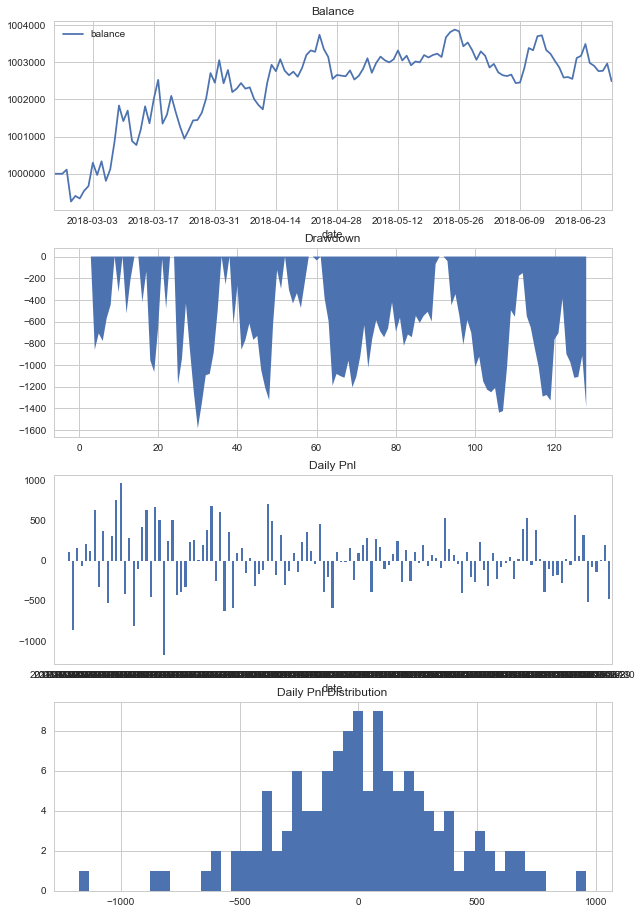

2018-07-14 16:48:15.999417	计算回测结果
2018-07-14 16:48:16.002413	------------------------------
2018-07-14 16:48:16.002413	第一笔交易：	2018-02-27 08:01:00
2018-07-14 16:48:16.002413	最后一笔交易：	2018-06-30 23:59:00
2018-07-14 16:48:16.002413	总交易次数：	43
2018-07-14 16:48:16.003412	总盈亏：	2,486.53
2018-07-14 16:48:16.003412	最大回撤: 	-1,342.64
2018-07-14 16:48:16.003412	平均每笔盈利：	57.83
2018-07-14 16:48:16.003412	平均每笔滑点：	0.4
2018-07-14 16:48:16.003412	平均每笔佣金：	15.91
2018-07-14 16:48:16.003412	胜率		32.56%
2018-07-14 16:48:16.003412	盈利交易平均值	642.65
2018-07-14 16:48:16.003412	亏损交易平均值	-224.5
2018-07-14 16:48:16.003412	盈亏比：	2.86


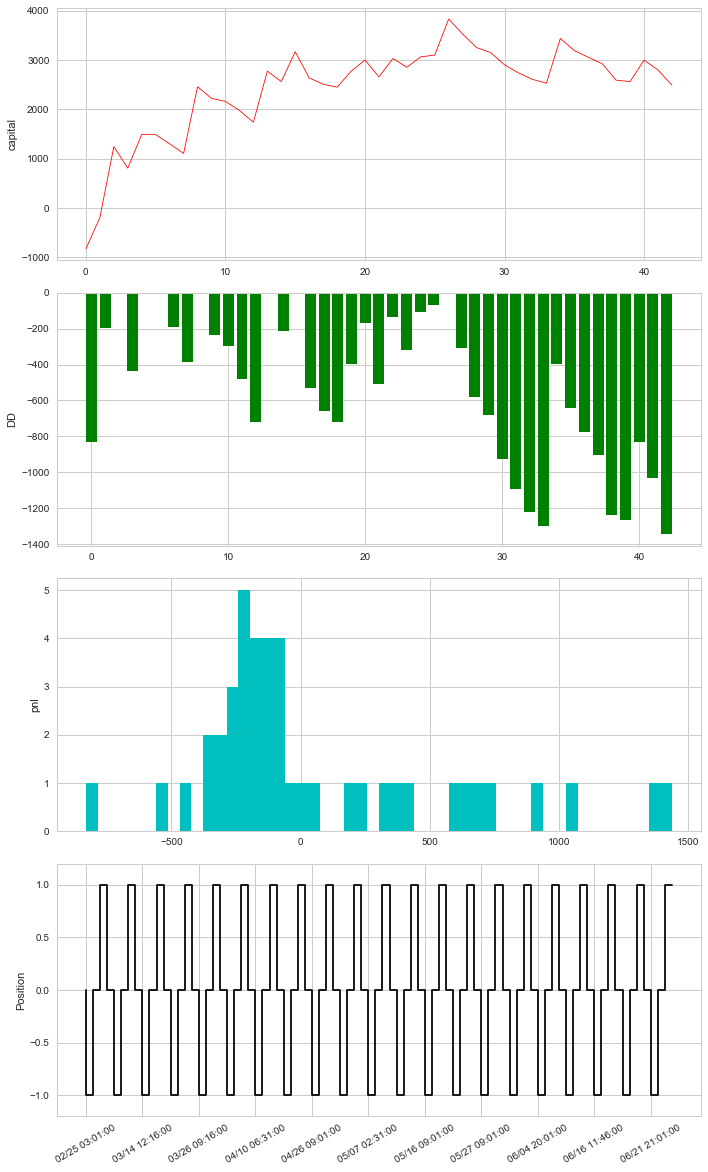

In [22]:
from __future__ import division
from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate,
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta
from datetime import datetime, timedelta
import pandas as pd

########################################################################
# 策略继承CtaTemplate
class StepOptimizeMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'StepOptimizeMaStrategy'
    author = 'ChannelCMT'

    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典

    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位

    # 策略参数
#     fastWindow = 40     # 快速均线参数
#     slowWindow = 70     # 慢速均线参数
    amWindow = 100
    parameterDf = stepParameter
    initDays = 1       # 初始化数据所用的天数

    # 策略变量
    fastMa0 = EMPTY_FLOAT   # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT   # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT   # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT   # 上一根的慢速EMA
    maTrend = 0             # 均线趋势，多头1，空头-1
    parameter = pd.DataFrame()
    stepDate = 20

    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow',
                 'parameterDict',
                 'amWindow']

    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1',
               'maTrend',
               'parameter',
               'runDays']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):

        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(StepOptimizeMaStrategy, self).__init__(ctaEngine, setting)

        # 生成仓位记录的字典
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"


        self.bg60 = BarGenerator(self.onBar, 60, self.on60MinBar)
        self.bg60Dict = {
            sym: self.bg60
            for sym in self.symbolList
        }


        self.bg15 = BarGenerator(self.onBar, 15, self.on15MinBar)
        self.bg15Dict = {
            sym: self.bg15
            for sym in self.symbolList
        }

        # 生成Bar数组
        self.am60Dict = {
            sym: ArrayManager(size=self.amWindow)
            for sym in self.symbolList
        }

        self.am15Dict = {
            sym: ArrayManager(size=self.amWindow)
            for sym in self.symbolList
        }

        self.i = 0
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        if not self.posDict:
            for symbolPos in [self.Longpos,self.Shortpos]:
                self.posDict[symbolPos] = 0

        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)

        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()

    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()

    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass

    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll()
        symbol = bar.vtSymbol
        # 基于60分钟判断趋势过滤，因此先更新
        bg60 = self.bg60Dict[symbol]
        bg60.updateBar(bar)

        # 基于15分钟判断
        bg15 = self.bg15Dict[symbol]
        bg15.updateBar(bar)

    #----------------------------------------------------------------------
    def on60MinBar(self, bar):
        """60分钟K线推送"""
#         print(datetime.strptime(bar.date, "%Y%m%d"))
#         print(self.parameterDf)
#         print(self.parameterDf.index[self.i])
        if datetime.strptime(bar.date, "%Y%m%d")<=self.parameterDf.index[self.i]+timedelta(days=self.stepDate):
            self.parameter = self.parameterDf.iloc[self.i]
        elif datetime.strptime(bar.date, "%Y%m%d")>=self.parameterDf.index[self.i]+timedelta(days=self.stepDate):
            self.i = self.i + 1
        else:
            return

        symbol = bar.vtSymbol
        am60 = self.am60Dict[symbol]
        am60.updateBar(bar)

        if not am60.inited:
            return

        # 计算均线并判断趋势
        fastMa = ta.MA(am60.close, self.parameter['fastWindow'])
        slowMa = ta.MA(am60.close, self.parameter['slowWindow'])

        if fastMa[-1] > slowMa[-1]:
            self.maTrend = 1
        else:
            self.maTrend = -1
#         发出状态更新事件
        self.putEvent()
    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol

        am15 = self.am15Dict[symbol]
        am15.updateBar(bar)
        if not am15.inited:
            return

        fastMa = ta.EMA(am15.close, self.parameter['fastWindow'])

        self.fastMa0 = fastMa[-1]
        self.fastMa1 = fastMa[-2]

        slowMa = ta.EMA(am15.close, self.parameter['slowWindow'])
        self.slowMa0 = slowMa[-1]
        self.slowMa1 = slowMa[-2]

        # 判断买卖
        crossOver = self.fastMa0>self.fastMa1 and self.slowMa0>self.slowMa1     # 均线上涨
        crossBelow = self.fastMa0<self.fastMa1 and self.slowMa0<self.slowMa1    # 均线下跌

        # 金叉和死叉的条件是互斥
        if crossOver and self.maTrend==1:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] == 1:
                self.cover(symbol,bar.close, 1)
                self.buy(symbol,bar.close, 1)

        # 死叉和金叉相反
        elif crossBelow and self.maTrend==-1:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close, 1)
            elif self.posDict[self.Longpos] == 1:
                self.sell(symbol,bar.close, 1)
                self.short(symbol,bar.close, 1)


        # 发出状态更新事件
        self.putEvent()

    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
#         print(self.posDict)
        pass

    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

if __name__=="__main__":
    from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME
    # 创建回测引擎对象
    engine = BacktestingEngine()
    # 设置回测使用的数据
    engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
    engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
    engine.setStartDate('20180222',initDays=1)               # 设置回测用的数据起始日期
    engine.setEndDate('20180630')
    # 配置回测引擎参数
    engine.setSlippage(0.2)     # 设置滑点为股指1跳
    engine.setRate(1/1000)   # 设置手续费万0.3
    engine.setSize(1)         # 设置合约大小
    # engine.setPriceTick(0.01)    # 设置股指最小价格变动
    engine.setCapital(1000000)  # 设置回测本金

    # # 在引擎中创建策略对象
    d = {'symbolList':['tBTCUSD:bitfinex']}          # 策略参数配置
    engine.initStrategy(StepOptimizeMaStrategy, d)    # 创建策略对象
    engine.runBacktesting()
    # 显示逐日回测结果
    engine.showDailyResult()
    # 显示逐笔回测结果
    engine.showBacktestingResult()

In [25]:
# 显示前10条成交记录
for i in range(100):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-02-25 03:01:00, Direction: 空, Price: 9520.9, Volume: 1
TradeID: 2, Time: 2018-02-27 08:01:00, Direction: 多, Price: 10332.0, Volume: 1
TradeID: 3, Time: 2018-02-27 08:01:00, Direction: 多, Price: 10332.0, Volume: 1
TradeID: 4, Time: 2018-03-06 23:01:00, Direction: 空, Price: 10989.0, Volume: 1
TradeID: 5, Time: 2018-03-06 23:01:00, Direction: 空, Price: 10989.0, Volume: 1
TradeID: 6, Time: 2018-03-12 12:46:00, Direction: 多, Price: 9529.9, Volume: 1
TradeID: 7, Time: 2018-03-12 12:46:00, Direction: 多, Price: 9529.9, Volume: 1
TradeID: 8, Time: 2018-03-14 12:16:00, Direction: 空, Price: 9113.0, Volume: 1
TradeID: 9, Time: 2018-03-14 12:16:00, Direction: 空, Price: 9113.0, Volume: 1
TradeID: 10, Time: 2018-03-20 05:01:00, Direction: 多, Price: 8410.3, Volume: 1
TradeID: 11, Time: 2018-03-20 05:01:00, Direction: 多, Price: 8410.3, Volume: 1
TradeID: 12, Time: 2018-03-23 14:01:00, Direction: 空, Price: 8420.0, Volume: 1
TradeID: 13, Time: 2018-03-23 14:01:00, Direction: 空, Pri

KeyError: '86'